# GLMM Analysis

**Important 🚨:** If only the demo data for the most common nine species is used, the results produced for all 52 species will naturally be different from the display items in the publication.


## Setup


In [3]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
def fx(df, change):
    if change in ["warmer", "cooler"]:
        values = df.query("change_temp_all == @change")["pval_temp"]
        mean = values.mean()
    else:
        values = df.query("change_spei_all == @change")["pval_spei"]
        mean = values.mean()

    # print(f"Mean p-value for {change}: {mean:.2f}")
    ax, fig = plt.subplots(figsize=(3, 3))
    sns.histplot(values, kde=True, bins=20)
    # Add legend
    plt.legend([f"{change} mean: {mean:.2f}"])
    plt.show()


def get_var_and_val(df_tmp, response_var, var_pval_threshold=0.05, group_threshold=0.6):

    pvar = f"pval_{response_var}"
    # df_tmp = df_tmp[df_tmp[pvar] < var_pval_threshold]
    # display(df_tmp)

    df_tmp = (
        df_tmp[f"response_{response_var}"]
        .value_counts(normalize=True)
        .sort_values(ascending=False)
    )
    ipattern = df_tmp.index[0]
    ivalue = df_tmp.values[0]
    if ivalue < group_threshold:
        ipattern = "ns"

    return ipattern, ivalue


def plot_pattern_dist(df_in, var_in, dir_patterns=None):
    # Sum up runs per group
    df_in = (
        df_in.groupby(var_in).agg(group_size_rel=("group_size", "sum")).reset_index()
    )
    # Take percentage and turn into int
    df_in["group_size_rel"] = (
        df_in["group_size_rel"] / df_in["group_size_rel"].sum() * 100
    )
    df_in["group_size_rel"] = df_in["group_size_rel"].round(0)
    df_in["group_size_rel"] = df_in["group_size_rel"].astype(int)
    # Sort by percentage
    df_in = df_in.sort_values("group_size_rel", ascending=True)
    # Add percentage to label
    df_in["change_simple"] = df_in[var_in]
    df_in[var_in] = df_in[var_in] + " (" + df_in["group_size_rel"].astype(str) + "%)"
    # Plot it
    df_in = df_in.sort_values("group_size_rel", ascending=False).reset_index(drop=True)
    # display(df_in)
    return df_in
    # df_in.plot(kind="barh", x=var_in, y="group_size_rel", color="grey", legend=False)
    # plt.xlabel("Share of all runs (%)")
    # plt.ylabel("")
    # plt.tight_layout()
    # plt.savefig(f"{dir_patterns}/change_counts_before_merging_unclear_{var_in}.png")
    # plt.show()
    # plt.close()


def plot_bars_dataset_pattern(
    patterns_merged,
    all_dfs,
    all_or_top9="all",
    color_temp="#77422C",
    color_spei="#D1A289",
    color_rest="lightgrey",
    color_wd="#B2182B",  # Original: "#B2182B"
    color_ww="#2166AC",  # Original: "#2166AC"
    color_other="lightgrey",
    color_cd="lightgrey",  # Original: "#EF8A62",
    color_cw="lightgrey",  # Original: "#67A9CF",
    ytick_labels=None,
    left_ylim=60,
    base_fontsize=12,
    filepath=None,
):
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs = axs.flatten()

    # ! Position of temp and cwb in the dataframe
    if all_or_top9 == "top9":
        pos_temp = 5
        pos_spei = 6
    elif all_or_top9 == "all":
        pos_temp = 5
        pos_spei = 3

    ax_dataset_boxplot(
        axs[0],
        all_dfs,
        all_dfs.columns[2:].tolist(),
        base_fontsize,
        pos_spei=pos_spei,
        pos_temp=pos_temp,
        color_spei=color_spei,
        color_temp=color_temp,
        color_rest=color_rest,
        all_or_top9=all_or_top9,
    )
    axs[0].set_xlim(0, left_ylim)

    # ax_dataset_boxplot(
    #     axs[0],
    #     all_dfs,
    #     imps,
    #     base_fontsize,
    #     color_spei=color_spei,
    #     color_temp=color_temp,
    #     color_rest=color_rest,
    #     all_or_top9=all_or_top9,
    # )

    # Barplot for patterns
    sns.barplot(
        data=patterns_merged,
        x="group_size_rel",
        y="change_simple",
        hue="change_simple",
        palette=[
            color_temp,
            color_temp,
            color_temp,
            color_spei,
            color_spei,
            color_spei,
            color_wd,
            color_ww,
            color_other,
            color_cd,
            color_cw,
        ],
        orient="h",
        height=0.5,
        dodge=False,
        edgecolor="black",
        # hue="response_spei",
        # palette=[
        #     "#B2182B",
        #     "#2166AC",
        #     "grey",
        # ],
        ax=axs[1],
    )

    # Add values to end of bars
    for i in range(len(patterns_merged)):
        axs[1].text(
            patterns_merged.loc[i, "group_size_rel"] + 1,
            i + -0.1,
            # f"{patterns_merged.loc[i, 'group_size_rel']} %",
            f"{patterns_merged.loc[i, 'group_size_rel']} % (sign: {patterns_merged.loc[i, 'perc_sign'].round(0).astype(int)}%)",
            va="center",
            fontsize=base_fontsize * 0.9,
        )

    # Add horizontal lines
    axs[1].axhline(2.35, color="black", linewidth=1)
    axs[1].axhline(5.35, color="black", linewidth=1)

    # Add text
    axs[1].text(
        95,
        2,
        "Temperature\nanomaly",
        ha="right",
        fontweight="bold",
        fontsize=base_fontsize * 1,
    )
    axs[1].text(
        95,
        5,
        "CWB anomaly",
        ha="right",
        fontweight="bold",
        fontsize=base_fontsize * 1,
    )
    axs[1].text(
        95,
        10,
        "Combined",
        ha="right",
        fontweight="bold",
        fontsize=base_fontsize * 1,
    )

    # Add labels
    axs[1].set_xlabel(
        "Model frequency (%)",
        fontweight="bold",
        labelpad=10,
        fontsize=base_fontsize * 1.2,
    )
    axs[1].set_ylabel(
        # "Climatic conditions before 2$^{\\text{nd}}$ visit",
        "Short-term climatic condition\npromoting mortality",
        labelpad=10,
        fontweight="bold",
        fontsize=base_fontsize * 1.2,
    )

    # Fix y-ticks
    if ytick_labels is not None:
        axs[1].set_yticklabels(ytick_labels, fontsize=base_fontsize * 1)

    axs[1].set_yticks(range(len(patterns_merged["change_simple"])))
    axs[1].tick_params(axis="y", which="both", left=False)

    # Fix axis limits
    axs[1].set_xlim(0, 100)
    axs[1].set_ylim(10.4, -0.4)

    # Remove top and right axis
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)

    # Add letters
    letters = ["A", "B"]
    for i, ax in enumerate(axs):
        ax.text(
            -0.5,
            0.99,
            letters[i],
            transform=ax.transAxes,
            fontsize=base_fontsize * 1.3,
            fontweight="bold",
        )

    # Fix layout
    # Fix x-tick size
    axs[0].tick_params(axis="x", which="both", labelsize=base_fontsize * 0.8)
    axs[1].tick_params(axis="x", which="both", labelsize=base_fontsize * 0.8)
    plt.tight_layout(w_pad=2, h_pad=1)

    if filepath is not None:
        plt.savefig(filepath, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close()


def get_ns_per_pattern(df_in, pattern):
    if pattern == "warmer" or pattern == "cooler":
        var_all = "change_temp_all"
        var_sign = "change_temp"
    elif pattern == "wetter" or pattern == "drier":
        var_all = "change_spei_all"
        var_sign = "change_spei"
    else:
        var_all = "change_both_all"
        var_sign = "change_both_sign"

    # Remove NAs in the pattern column to avoid confusion with "ns" as relating to variable was not contained in the model and "ns" as relating to no significant pvalue
    df_in = df_in.dropna(subset=[var_all])

    # Get NA percentage
    df_in = df_in.query(f"{var_all} == '{pattern}'")[var_sign].value_counts(
        normalize=True
    )["ns"]

    # Return
    return df_in

## Settings


In [5]:
# Get todays analysis folder
from datetime import datetime

dir_today = f"./model_analysis/{datetime.now().strftime('%Y-%m-%d')}/glmm_analysis"
os.makedirs(dir_today, exist_ok=True)
dir_today

'./model_analysis/2025-02-27/glmm_analysis'

In [6]:
# Model selection
add_spei_temp_interaction = False
add_spei_temp_derivatives = False

do_rfe = False
rfe_with_interactions = False
best_model_method = "AIC"

# Model filter
all_or_top9 = "all"
roc_threshold = 0.6
pval_threshold = 0.05
min_group_percentage = 0.6
ns_for_insignificant = False

# Get paths
path_prefix = "./model_runs/all_runs/"
path_suffix = f"glmm/all_interactions_{rfe_with_interactions}-climate_interaction_{add_spei_temp_interaction}-climate_derivatives_{add_spei_temp_derivatives}/rfe_{do_rfe}/"
if do_rfe:
    path_suffix += f"best_model_{best_model_method}/"

print(f"Saving to {path_prefix}/RUN/SPECIES/{path_suffix}")

Saving to ./model_runs/all_runs//RUN/SPECIES/glmm/all_interactions_False-climate_interaction_False-climate_derivatives_False/rfe_False/


## List of Species and Models


In [7]:
final_species = get_species_with_models("list")

top9 = final_species[:9]

base_dir = "./model_runs/all_runs/"
models_dir = os.listdir(base_dir)
models_dir = [m for m in models_dir if not m.startswith(".")]
models_dir = sorted(models_dir)

# Merge species and model lists into one df
models_species = list(itertools.product(models_dir, final_species))
df_in = pd.DataFrame(models_species, columns=["model", "species"])
df_in

,model,species
0,run_1220,Fagus sylvatica
1,run_1220,Quercus robur
2,run_1220,Quercus petraea
3,run_1220,Carpinus betulus
4,run_1220,Castanea sativa
...,...,...
2595,run_9998,Abies grandis
2596,run_9998,Alnus incana
2597,run_9998,Laburnum anagyroides
2598,run_9998,Prunus mahaleb


## Single Runs


In [8]:
# i = 0
# ispecies = "Juniperus communis"
# imodel = df_in.loc[0, "model"]

# glmm_run_per_species_and_model(
#     ispecies,
#     imodel,
#     verbose=True,
#     do_rfe=do_rfe,
#     rfe_with_interactions=rfe_with_interactions,
#     add_spei_temp_interaction=add_spei_temp_interaction,
#     add_spei_temp_derivatives=add_spei_temp_derivatives,
#     best_model_method=best_model_method,
#     path_prefix=path_prefix,
#     path_suffix=path_suffix,
#     return_all=False,
#     skip_if_exists=True,
# )

## All runs


In [9]:
# from random_forest_utils import glmm_wrapper_loop

# # Run glmm fitting in parallel:
# out = run_mp(
#     glmm_wrapper_loop,
#     arg_list=split_df_into_list_of_group_or_ns(df_in, "model"),
#     num_cores=10,
#     progress_bar=True,
#     verbose=False,
#     do_rfe=do_rfe,
#     rfe_with_interactions=rfe_with_interactions,
#     add_spei_temp_interaction=add_spei_temp_interaction,
#     add_spei_temp_derivatives=add_spei_temp_derivatives,
#     best_model_method=best_model_method,
#     path_prefix=path_prefix,
#     path_suffix=path_suffix,
#     return_all=False,
#     skip_if_exists=True,
# )

In [10]:
# ! osascript -e 'tell app "System Events" to shut down'

## Check GLMM Runs


In [11]:
# Check which models have NO model created
i_missing = []
i_success = []
for i, row in df_in.reset_index(drop=True).iterrows():
    # Check for summary file because it is the last that should be saved per run
    path_glmm = f"{path_prefix}/{row.model}/{row.species}/{path_suffix}/summary.csv"
    if not os.path.isfile(path_glmm):
        i_missing.append(row)
    else:
        i_success.append(row)

if i_missing.__len__() > 0:
    print(f"Missing {i_missing.__len__()} models")
    i_missing = pd.concat(i_missing)
    i_missing = pd.DataFrame(
        {"model": i_missing.model.values, "species": i_missing.species.values}
    )
    print(
        f"Missing models: {i_missing.shape[0]} from {i_missing.model.nunique()} seeds and {i_missing.species.nunique()} species"
    )
else:
    print("All models are present")

i_success = pd.concat(i_success)
i_success = pd.DataFrame(
    {"model": i_success.model.values, "species": i_success.species.values}
)

print(
    f"Successful models: {i_success.shape[0]} from {i_success.model.nunique()} seeds and {i_success.species.nunique()} species"
)

All models are present
Successful models: 2600 from 50 seeds and 52 species


In [12]:
# # Loop over missing models to see which cause errors
# verbose = True
# for i, row in i_missing.reset_index(drop=True).iterrows():
#     if verbose:
#         print(f"🟡 Species: {row.species}\t | Model: {row.model}")

#     if "61" in row.model:
#         print("Skipping: Alnus incana 61")
#         continue

#     glmm_wrapper(
#         ispecies=row.species,
#         imodel=row.model,
#         base_dir="./model_runs/all_runs",
#         return_all=False,
#         verbose=False,
#     )
#     clear_output()
#     if verbose:
#         print(f"🟡 Species: {row.species}\t | Model: {row.model}")

## Compare RF and GLMM performance


### ROC-AUC


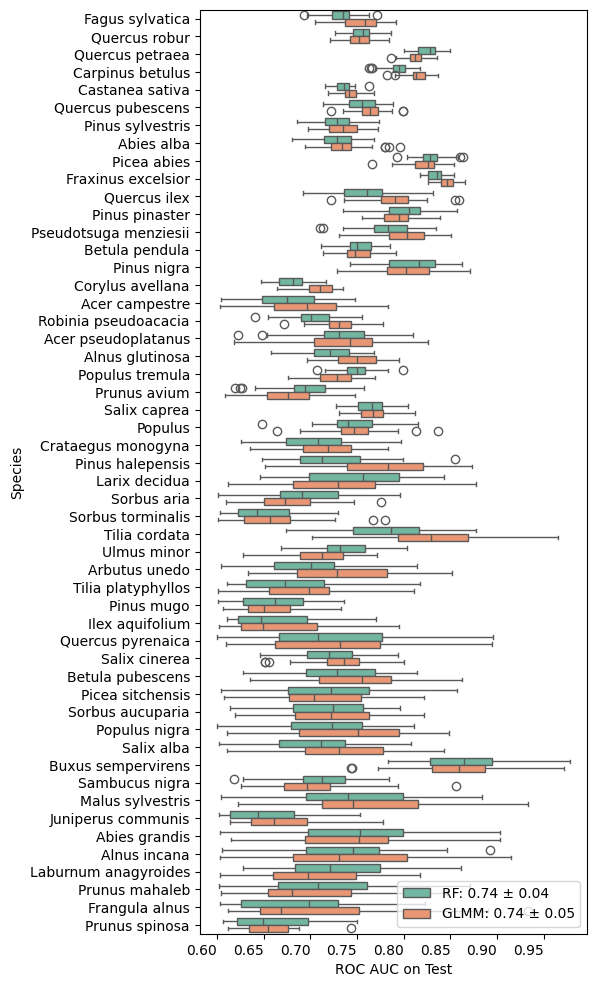

Comparison of random forest and logistic glmm models:
RF: 0.74 ± 0.04
GLMM: 0.74 ± 0.05


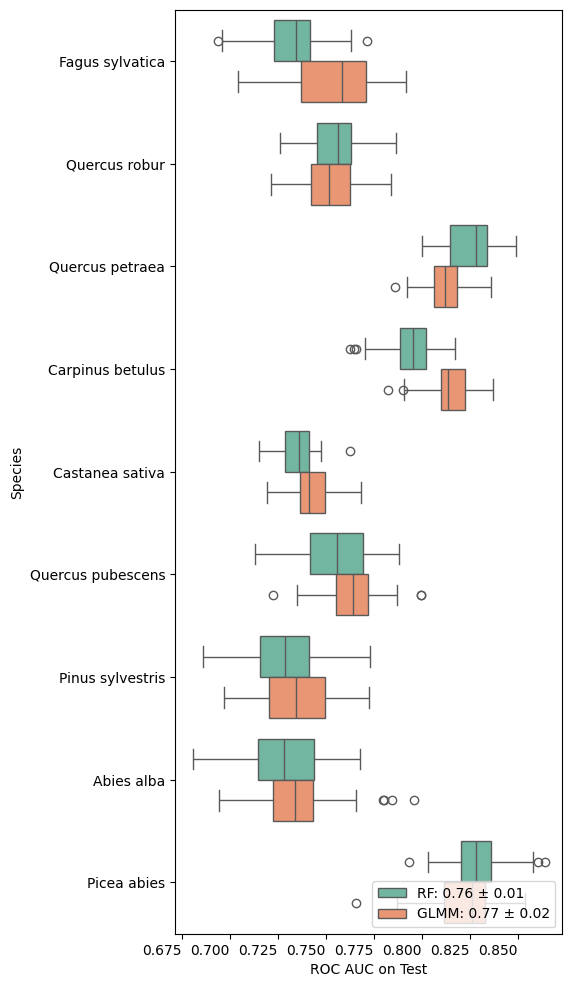

Comparison of random forest and logistic glmm models:
RF: 0.76 ± 0.01
GLMM: 0.77 ± 0.02


In [13]:
df_comp_perf = []

for i, row in i_success.iterrows():

    # Check if roc auc files are there
    path_rf = (
        f"./model_runs/all_runs/{row.model}/{row.species}/rf_performance/roc_auc.csv"
    )
    path_glmm = f"{path_prefix}/{row.model}/{row.species}/{path_suffix}/roc_auc.csv"

    if not os.path.isfile(path_glmm):
        print(f"GLMM file missing for {row.species} - {row.model}")
        continue
    if not os.path.isfile(path_rf):
        raise ValueError(f"RF file missing: {path_rf}")

    # Attach files
    irf = pd.read_csv(path_rf)
    irf["species"] = row.species
    irf["model"] = "rf"
    irf["run"] = row.model

    iglmm = pd.read_csv(path_glmm)
    iglmm["species"] = row.species
    iglmm["model"] = "glmm"
    iglmm["run"] = row.model

    df_comp_perf.append(irf)
    df_comp_perf.append(iglmm)

for subset in ["all", "top9"]:

    # Get data
    df_plot = pd.concat(df_comp_perf)
    df_plot = df_plot[df_plot["test_mean"] > roc_threshold]
    if subset == "top9":
        df_plot = df_plot[df_plot["species"].isin(top9)]

    # Get mean and std for each model
    metric_table = df_plot.groupby(["model"]).agg(
        {"test_mean": "mean", "test_sd": "mean"}
    )
    metric_rf = metric_table.loc["rf"]
    metric_rf = f"RF: {metric_rf.test_mean:.2f} ± {metric_rf.test_sd:.2f}"
    metric_glmm = metric_table.loc["glmm"]
    metric_glmm = f"GLMM: {metric_glmm.test_mean:.2f} ± {metric_glmm.test_sd:.2f}"

    # Replace model names with metrics
    df_plot["model"] = df_plot["model"].replace({"rf": metric_rf, "glmm": metric_glmm})

    # Create a boxplot
    plt.figure(figsize=(5, 12))
    sns.boxplot(
        data=df_plot,
        y="species",
        x="test_mean",
        hue="model",  # Different colors for each model
        palette="Set2",  # Change color palette as desired
    )

    # Add titles and labels
    # plt.title("Boxplot of Test Mean by Species and Model")
    plt.xlabel("ROC AUC on Test")
    plt.ylabel("Species")

    # Rotate x-axis labels
    # plt.xticks(rotation=45, ha="right")
    plt.xticks(fontsize=10, ha="right")

    # Show legend
    plt.legend(title=None, loc="lower right")

    if subset == "all":
        plt.savefig(
            f"{dir_today}/roc_auc_all_species.png",
            dpi=300,
            bbox_inches="tight",
        )

    # Show plot
    plt.show()

    # Verbose
    print("Comparison of random forest and logistic glmm models:")
    print(metric_rf)
    print(metric_glmm)

### PR-AUC


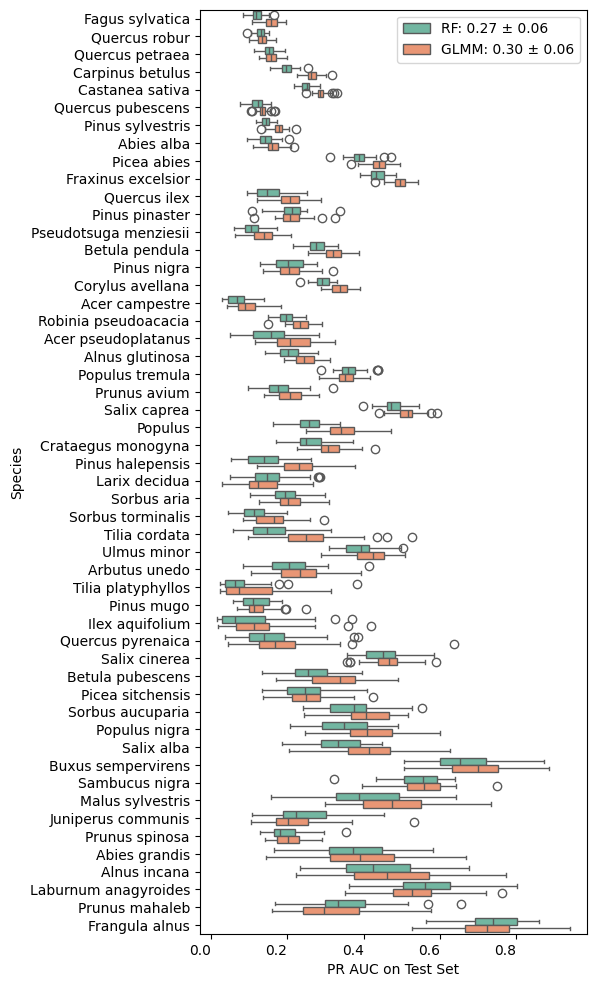

Comparison of random forest and logistic glmm models:
RF: 0.27 ± 0.06
GLMM: 0.30 ± 0.06


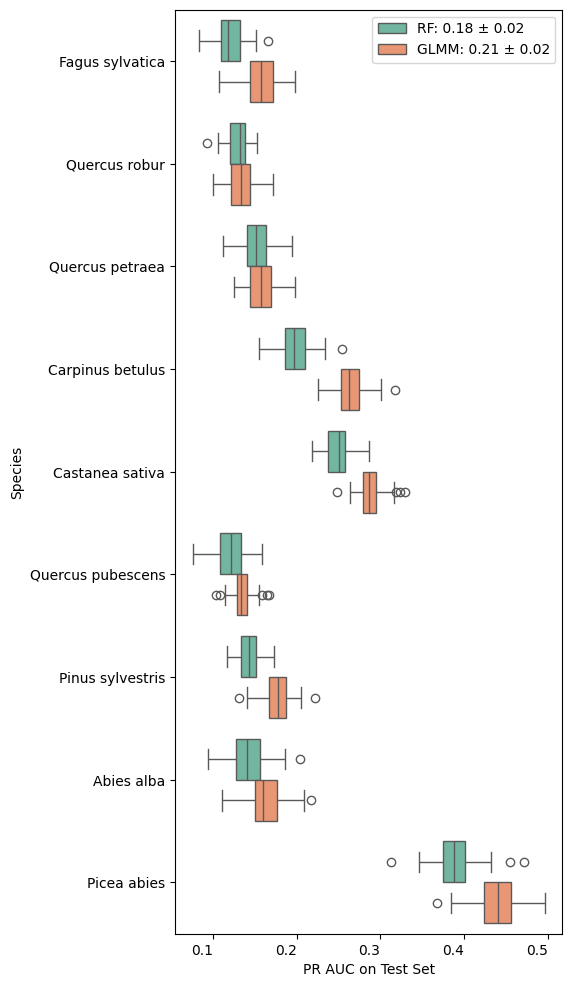

Comparison of random forest and logistic glmm models:
RF: 0.18 ± 0.02
GLMM: 0.21 ± 0.02


In [15]:
df_comp_perf = []

for i, row in i_success.iterrows():

    # Check if roc auc files are there
    path_rf = (
        f"./model_runs/all_runs/{row.model}/{row.species}/rf_performance/pr_auc.csv"
    )
    path_glmm = f"{path_prefix}/{row.model}/{row.species}/{path_suffix}/pr_auc.csv"

    if not os.path.isfile(path_glmm):
        print(f"GLMM file missing for {row.species} - {row.model}")
        continue
    if not os.path.isfile(path_rf):
        raise ValueError(f"RF file missing: {path_rf}")

    # Attach files
    irf = pd.read_csv(path_rf)
    irf["species"] = row.species
    irf["model"] = "rf"
    irf["run"] = row.model

    iglmm = pd.read_csv(path_glmm)
    iglmm["species"] = row.species
    iglmm["model"] = "glmm"
    iglmm["run"] = row.model

    df_comp_perf.append(irf)
    df_comp_perf.append(iglmm)

for subset in ["all", "top9"]:

    # Get data
    df_plot = pd.concat(df_comp_perf)
    # df_plot = df_plot[df_plot["test_mean"] > roc_threshold]
    if subset == "top9":
        df_plot = df_plot[df_plot["species"].isin(top9)]

    # Get mean and std for each model
    metric_table = df_plot.groupby(["model"]).agg(
        {"test_mean": "mean", "test_sd": "mean"}
    )
    metric_rf = metric_table.loc["rf"]
    metric_rf = f"RF: {metric_rf.test_mean:.2f} ± {metric_rf.test_sd:.2f}"
    metric_glmm = metric_table.loc["glmm"]
    metric_glmm = f"GLMM: {metric_glmm.test_mean:.2f} ± {metric_glmm.test_sd:.2f}"

    # Replace model names with metrics
    df_plot["model"] = df_plot["model"].replace({"rf": metric_rf, "glmm": metric_glmm})

    # Create a boxplot
    plt.figure(figsize=(5, 12))
    sns.boxplot(
        data=df_plot,
        y="species",
        x="test_mean",
        hue="model",  # Different colors for each model
        palette="Set2",  # Change color palette as desired
    )

    # Add titles and labels
    # plt.title("Boxplot of Test Mean by Species and Model")
    plt.xlabel("PR AUC on Test Set")
    plt.ylabel("Species")

    # Rotate x-axis labels
    # plt.xticks(rotation=45, ha="right")
    plt.xticks(ha="right", fontsize=10)

    # Show legend
    plt.legend(title=None)

    # Show plot
    plt.show()

    # Verbose
    print("Comparison of random forest and logistic glmm models:")
    print(metric_rf)
    print(metric_glmm)

In [16]:
def ax_performance(ax, roc_or_auc):

    if roc_or_auc == "roc":
        metric = "ROC AUC"
        file_name = "roc_auc"
    elif roc_or_auc == "pr":
        metric = "PR AUC"
        file_name = "pr_auc"
    else:
        raise ValueError("roc_or_auc must be 'roc' or 'pr'")

    df_comp_perf = []

    for i, row in i_success.iterrows():

        # Check if roc auc files are there
        path_rf = f"./model_runs/all_runs/{row.model}/{row.species}/rf_performance/{file_name}.csv"
        path_glmm = (
            f"{path_prefix}/{row.model}/{row.species}/{path_suffix}/{file_name}.csv"
        )

        if not os.path.isfile(path_glmm):
            print(f"GLMM file missing for {row.species} - {row.model}")
            continue
        if not os.path.isfile(path_rf):
            raise ValueError(f"RF file missing: {path_rf}")

        # Attach files
        irf = pd.read_csv(path_rf)
        irf["species"] = row.species
        irf["model"] = "rf"
        irf["run"] = row.model

        iglmm = pd.read_csv(path_glmm)
        iglmm["species"] = row.species
        iglmm["model"] = "glmm"
        iglmm["run"] = row.model

        df_comp_perf.append(irf)
        df_comp_perf.append(iglmm)

    # Get data
    df_plot = pd.concat(df_comp_perf)
    if roc_or_auc == "roc":
        df_plot = df_plot[df_plot["test_mean"] > roc_threshold]

    # Get mean and std for each model
    metric_table = df_plot.groupby(["model"]).agg(
        {"test_mean": "mean", "test_sd": "mean"}
    )
    metric_rf = metric_table.loc["rf"]
    metric_rf = f"RF: {metric_rf.test_mean:.2f} ± {metric_rf.test_sd:.2f}"
    metric_glmm = metric_table.loc["glmm"]
    metric_glmm = f"GLMM: {metric_glmm.test_mean:.2f} ± {metric_glmm.test_sd:.2f}"

    # Replace model names with metrics
    df_plot["model"] = df_plot["model"].replace({"rf": metric_rf, "glmm": metric_glmm})

    sns.boxplot(
        data=df_plot,
        y="species",
        x="test_mean",
        hue="model",  # Different colors for each model
        palette="Set2",  # Change color palette as desired
        ax=ax,
    )

    # Add titles and labels to the given ax
    ax.set_xlabel(f"{metric} on Test Set", fontsize=10, fontweight="bold")
    if roc_or_auc == "roc":
        ax.set_ylabel("Species", fontsize=10, fontweight="bold")

    # Rotate x-axis labels
    ax.tick_params(axis="x", labelrotation=0, labelsize=10)

    # Show legend on the ax
    pos = "upper right"  # if roc_or_auc == "pr" else "upper left"
    ax.legend(title=None, loc=pos, fontsize=8, handlelength=0.8)

    # Verbose
    print("Comparison of random forest and logistic glmm models:")
    print(metric_rf)
    print(metric_glmm)

    return ax

Comparison of random forest and logistic glmm models:
RF: 0.74 ± 0.04
GLMM: 0.74 ± 0.05
Comparison of random forest and logistic glmm models:
RF: 0.27 ± 0.06
GLMM: 0.30 ± 0.06


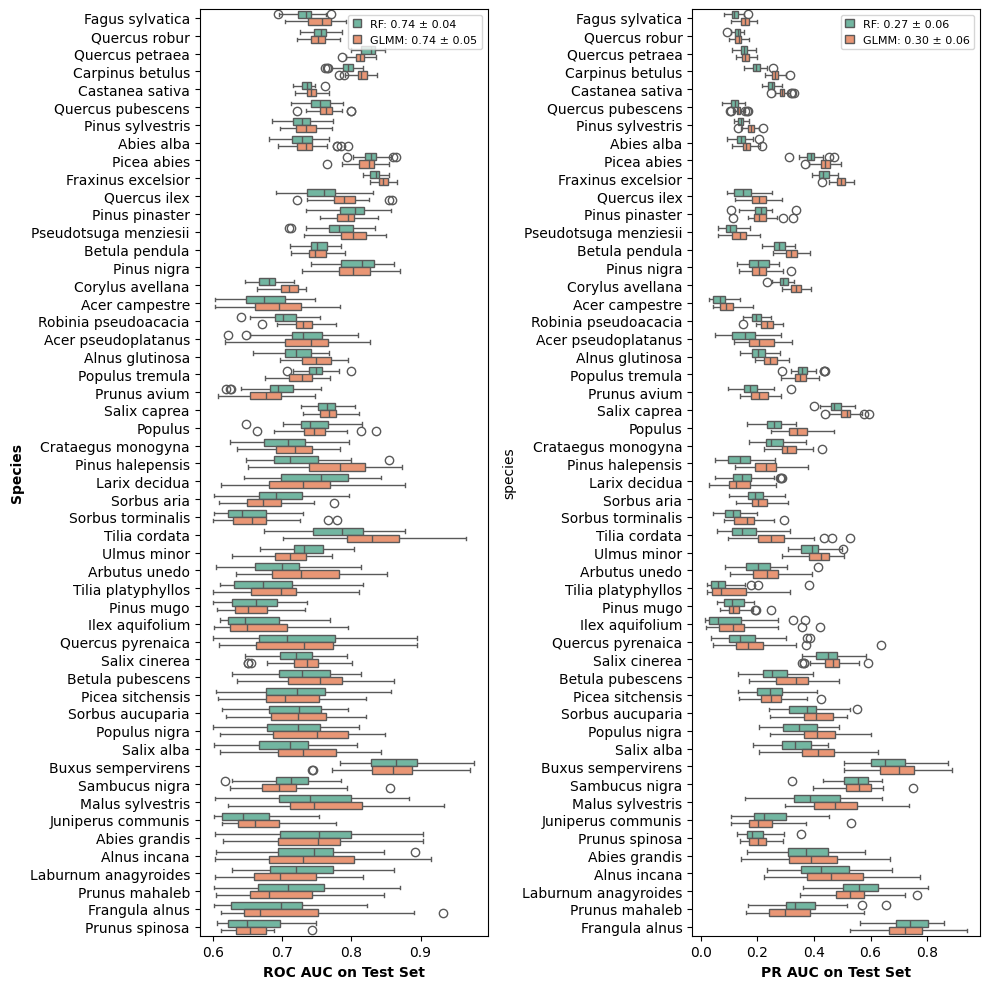

In [17]:
# Create figure
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
ax_performance(axs[0], "roc")
ax_performance(axs[1], "pr")
fig.tight_layout()
save_path = f"{dir_today}/performance_comparison-all_species.png"
fig.savefig(save_path, dpi=300, bbox_inches="tight")

## Variable importance comparison


In [18]:
# Load and concat all results

df_all = []
for ispecies in final_species:
    for imodel in models_dir:

        path = f"{path_prefix}/{imodel}/{ispecies}/{path_suffix}/summary.csv"

        # Load if file exists
        if os.path.isfile(path):
            idf = pd.read_csv(
                path,
                index_col=0,
            )[["Estimate", "P-val", "2.5_ci", "97.5_ci", "SE"]]

            # Generalize columns names based on category
            idf["dataset"] = idf.index.map(get_category_from_var_wrapper)
            idf = idf.reset_index().rename({"index": "variable"}, axis=1)

            # Add info
            idf["species"] = ispecies
            idf["model"] = imodel
            idf = move_vars_to_front(idf, ["species", "model", "dataset", "variable"])
            df_all.append(idf)
        else:
            pass
            print(f"Missing: {ispecies} - {imodel}")


# Load data
df_vimp = pd.concat(df_all)
df_vimp = df_vimp[["species", "model", "dataset", "Estimate"]]

# Take estimate as importance proxy by taking the absolute value
df_vimp["Estimate"] = df_vimp["Estimate"].abs() * 100

# Merge interaction variables
df_vimp["dataset"] = df_vimp["dataset"].str.replace(
    "Interaction_SPEI_Temperature", "Interaction_Temperature_SPEI"
)

# Take the mean per model-species-dataset combination (e.g. there are two temperature variables when linear and quad. are included)
df_vimp = df_vimp.groupby(["species", "model", "dataset"]).mean().reset_index()

# # Make wide df_vimp
df_vimp = df_vimp.pivot(
    index=["species", "model"], columns="dataset", values="Estimate"
).reset_index()

# Drop intercept columns
df_vimp = df_vimp.drop("Intercept", axis=1)

# For each row, divide the estimate by the sum of the estimates for that row
df_vimp.iloc[:, 2:] = (
    df_vimp.iloc[:, 2:].div(df_vimp.iloc[:, 2:].sum(axis=1), axis=0) * 100
)

# Display
df_vimp.head(5)

dataset,species,model,Light Competition,Management,NDVI,SPEI,Soil Fertility,Soil Water Conditions,Species Competition,Stand Structure,Temperature,Topography,Tree Size
0,Abies alba,run_1220,1.005444,2.370784,6.325702,5.856858,10.618081,0.980477,5.034737,18.155680,13.988254,2.547877,33.116106
1,Abies alba,run_1221,0.864403,2.317298,13.276631,9.248090,8.284951,9.317886,2.827349,5.295827,2.009885,7.948260,38.609419
2,Abies alba,run_1222,2.630324,3.624537,2.915798,10.004167,6.708528,3.124762,4.013966,16.911851,1.986009,6.693290,41.386767
3,Abies alba,run_1223,0.881965,2.011903,9.473598,7.623923,3.647930,9.931928,1.546920,11.694584,4.956608,16.157096,32.073544
4,Abies alba,run_1224,2.568414,1.550332,4.103455,6.584781,2.267186,3.563771,4.269417,17.011790,5.433796,9.715507,42.931550


🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


(0.0, 100.0)

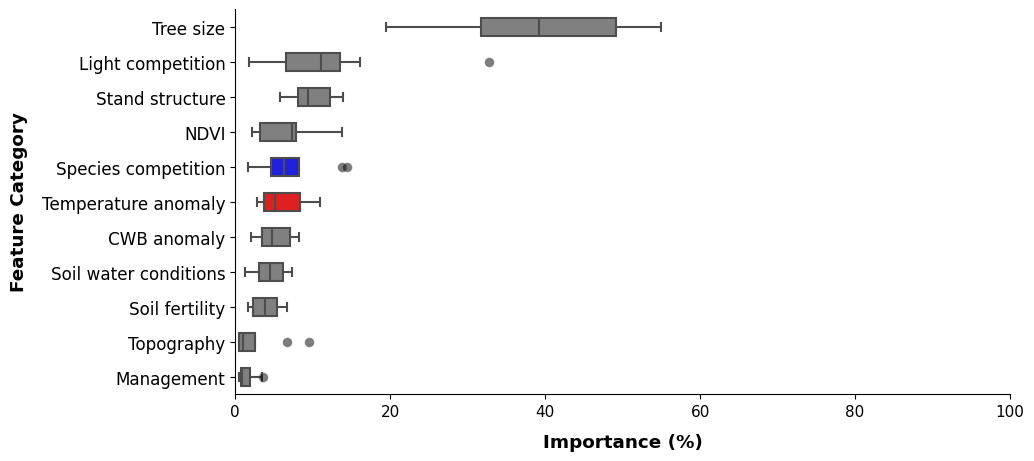

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax_dataset_boxplot(
    ax,
    df_vimp,
    df_vimp.columns[2:].tolist(),
    base_fontsize=11,
    pos_spei=4,
    pos_temp=5,
    all_or_top9="top9",
)
ax.set_xlim(0, 100)

## Investigate climate effect


### At model-level


In [20]:
df_speitemp_list = []

for i, row in i_success.iterrows():

    # Check if roc auc files are there
    path_glmm = f"{path_prefix}/{row.model}/{row.species}/{path_suffix}/summary.csv"
    path_perf = f"{path_prefix}/{row.model}/{row.species}/{path_suffix}/roc_auc.csv"

    if not os.path.isfile(path_glmm) or not os.path.isfile(path_perf):
        print(f" - 🚨 GLMM files incomplete for {row.species} - {row.model}")
        continue

    # Load data
    iper = pd.read_csv(path_perf)
    isry = pd.read_csv(path_glmm, index_col=0)
    var_spei = glmm_get_spei_var(isry.index)
    var_temp = glmm_get_temp_var(isry.index)

    if var_spei is None:
        esti_spei = None
        sign_spei = None
        dire_spei = None
        pval_spei = None
        change_spei = None
    else:
        esti_spei = isry.loc[[var_spei]]["Estimate"].values[0]
        sign_spei = isry.loc[[var_spei]]["Sig"].values[0]
        dire_spei = np.sign(isry.loc[[var_spei]]["Estimate"].values[0])
        pval_spei = isry.loc[[var_spei]]["P-val"].values[0]

        if pval_spei < pval_threshold:
            if dire_spei > 0:
                change_spei = "wetter"
            else:
                change_spei = "drier"
        else:
            change_spei = "ns"

    if var_temp is None:
        esti_temp = None
        sign_temp = None
        dire_temp = None
        pval_temp = None
        change_temp = None
    else:
        esti_temp = isry.loc[[var_temp]]["Estimate"].values[0]
        sign_temp = isry.loc[[var_temp]]["Sig"].values[0]
        dire_temp = np.sign(isry.loc[[var_temp]]["Estimate"].values[0])
        pval_temp = isry.loc[[var_temp]]["P-val"].values[0]

        if pval_temp < pval_threshold:
            if dire_temp > 0:
                change_temp = "warmer"
            else:
                change_temp = "cooler"
        else:
            change_temp = "ns"

    # Attach temp and spei information
    df_speitemp_list.append(
        pd.DataFrame(
            {
                "species": row.species,
                "run": row.model.split(" -")[0].split("_")[1],
                "spei": var_spei,
                "sign_spei": sign_spei,
                "dire_spei": dire_spei,
                "pval_spei": pval_spei,
                "change_spei": change_spei,
                "temp": var_temp,
                "sign_temp": sign_temp,
                "dire_temp": dire_temp,
                "pval_temp": pval_temp,
                "change_temp": change_temp,
                "test_roc_auc": iper["test_mean"].values[0],
            },
            index=[0],
        )
    )

# Get dictionary
dict_spei = {
    +1: "drier",
    -1: "wetter",
}

dict_temp = {
    +1: "warmer",
    -1: "cooler",
}

dict_ns = {
    "ns_ns": "ns",
    "ns_wetter": "ns",
    "ns_drier": "ns",
    "warmer_ns": "ns",
    "cooler_ns": "ns",
    "warmer_wetter": "warmer_wetter",
    "warmer_drier": "warmer_drier",
    "cooler_wetter": "cooler_wetter",
    "cooler_drier": "cooler_drier",
}

In [21]:
# Unlist data
df_pattern_per_model = pd.concat(df_speitemp_list)
df_pattern_per_model["change_spei_all"] = df_pattern_per_model["dire_spei"].map(
    dict_spei
)
df_pattern_per_model["change_temp_all"] = df_pattern_per_model["dire_temp"].map(
    dict_temp
)
df_pattern_per_model["change_both_all"] = (
    df_pattern_per_model["change_temp_all"]
    + "_"
    + df_pattern_per_model["change_spei_all"]
)
df_pattern_per_model["change_both_sign"] = (
    df_pattern_per_model["change_temp"] + "_" + df_pattern_per_model["change_spei"]
)
df_pattern_per_model["change_both_sign"] = df_pattern_per_model["change_both_sign"].map(
    dict_ns
)


for all_or_top9 in ["all", "top9"]:
    if all_or_top9 == "top9":
        text = "Top 9 species"
        df_tmp = df_pattern_per_model.query("species in @top9").copy()
    else:
        df_tmp = df_pattern_per_model.copy()
        text = "All species"

    display(f"----- 🚨 {text} ------")

    print("--- Change patterns all ---")
    display(df_tmp.change_temp_all.value_counts(normalize=True).sort_values().round(2))
    display(df_tmp.change_spei_all.value_counts(normalize=True).sort_values().round(2))
    display(df_tmp.change_both_all.value_counts(normalize=True).sort_values().round(2))

    print(f"--- Change patterns significant at p = {pval_threshold}---")
    display(df_tmp.change_temp.value_counts(normalize=True).sort_values().round(2))
    display(df_tmp.change_spei.value_counts(normalize=True).sort_values().round(2))
    print(f"- Both with ns")
    display(df_tmp.change_both_sign.value_counts(normalize=True).sort_values().round(2))
    print(f"- Both without ns")
    display(
        df_tmp.query("change_both_sign != 'ns'")
        .change_both_sign.value_counts(normalize=True)
        .sort_values()
        .round(2)
    )

    # fx(df_tmp, "wetter")
    # fx(df_tmp, "drier")
    # fx(df_tmp, "warmer")
    # fx(df_tmp, "cooler")

/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/2011284384.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pattern_per_model = pd.concat(df_speitemp_list)


'----- 🚨 All species ------'

--- Change patterns all ---


change_temp_all
cooler    0.35
warmer    0.65
Name: proportion, dtype: float64

change_spei_all
wetter    0.41
drier     0.59
Name: proportion, dtype: float64

change_both_all
cooler_wetter    0.17
cooler_drier     0.18
warmer_wetter    0.24
warmer_drier     0.41
Name: proportion, dtype: float64

--- Change patterns significant at p = 0.05---


change_temp
cooler    0.10
warmer    0.32
ns        0.58
Name: proportion, dtype: float64

change_spei
drier     0.16
wetter    0.28
ns        0.56
Name: proportion, dtype: float64

- Both with ns


change_both_sign
cooler_wetter    0.04
cooler_drier     0.04
warmer_drier     0.07
warmer_wetter    0.13
ns               0.73
Name: proportion, dtype: float64

- Both without ns


change_both_sign
cooler_wetter    0.14
cooler_drier     0.15
warmer_drier     0.24
warmer_wetter    0.47
Name: proportion, dtype: float64

'----- 🚨 Top 9 species ------'

--- Change patterns all ---


change_temp_all
cooler    0.15
warmer    0.85
Name: proportion, dtype: float64

change_spei_all
wetter    0.39
drier     0.61
Name: proportion, dtype: float64

change_both_all
cooler_wetter    0.07
cooler_drier     0.08
warmer_wetter    0.32
warmer_drier     0.52
Name: proportion, dtype: float64

--- Change patterns significant at p = 0.05---


change_temp
cooler    0.09
ns        0.24
warmer    0.67
Name: proportion, dtype: float64

change_spei
drier     0.25
ns        0.35
wetter    0.40
Name: proportion, dtype: float64

- Both with ns


change_both_sign
cooler_drier     0.03
cooler_wetter    0.05
warmer_drier     0.14
warmer_wetter    0.26
ns               0.51
Name: proportion, dtype: float64

- Both without ns


change_both_sign
cooler_drier     0.07
cooler_wetter    0.11
warmer_drier     0.28
warmer_wetter    0.54
Name: proportion, dtype: float64

In [22]:
keep_nonsignificant = True

if keep_nonsignificant:
    tmp_suffix = "_all"
else:
    tmp_suffix = ""

df_res_lm = (
    df_pattern_per_model.sort_values("species")
    .rename(
        columns={
            f"change_spei{tmp_suffix}": "response_spei",
            f"change_temp{tmp_suffix}": "response_temp",
        }
    )
    .query("test_roc_auc > @roc_threshold")
    .reset_index(drop=True)
)

# display(df_res_lm)

# Group by species and spei/temp variables
df_res_lm_group = (
    df_res_lm.dropna(subset=["response_spei", "response_temp"])
    # .query("dire_spei == 0 or dire_temp == 0")
    .groupby(["species", "spei", "temp"])
)

df_list = []

i = 0
ispecies = ""

for group in df_res_lm_group.groups:

    # Increment group counter
    if ispecies == group[0]:
        group_counter = group_counter + 1
    else:
        group_counter = 1
        ispecies = group[0]

    # Get group
    df_group = df_res_lm_group.get_group(group)
    # Get group size
    group_size = df_group.shape[0]
    # Get pattern percentages
    spei_pattern, spei_value = get_var_and_val(df_group, "spei", min_group_percentage)
    temp_pattern, temp_value = get_var_and_val(df_group, "temp", min_group_percentage)

    idf = pd.DataFrame(
        {
            "species": group[0],
            "spei": group[1],
            "temp": group[2],
            "group": group_counter,
            "group_size": group_size,
            "response_spei": spei_pattern,
            "response_temp": temp_pattern,
            "perc_spei": spei_value,
            "perc_temp": temp_value,
        },
        index=[0],
    )

    df_list.append(idf)
    # display(idf)
    # display(df_group)


# pd.concat(df_list)

In [23]:
# Load data
df_patterns = pd.concat(df_list)
df_patterns["change"] = (
    df_patterns["response_temp"] + "_" + df_patterns["response_spei"]
)

# If ns is in change, then it is ns
df_patterns["change"] = df_patterns["change"].apply(lambda x: "ns" if "ns" in x else x)
df_patterns.head(3)

,species,spei,temp,group,group_size,response_spei,response_temp,perc_spei,perc_temp,change
0,Abies alba,spei1_may_min,tmax_win_mean_anomaly,1,14,wetter,warmer,1.0,0.928571,warmer_wetter
0,Abies alba,spei1_may_min,tmoy_spr_min_anomaly,2,1,wetter,warmer,1.0,1.000000,warmer_wetter
0,Abies alba,spei1_may_min,tmoy_win_mean_anomaly,3,7,wetter,cooler,1.0,0.714286,cooler_wetter


In [24]:
# For all species
pattern_both = plot_pattern_dist(df_patterns, "change")
pattern_spei = plot_pattern_dist(df_patterns, "response_spei")
pattern_temp = plot_pattern_dist(df_patterns, "response_temp")

patterns_merged_allspecies = pd.concat(
    [
        pattern_temp.replace({"ns": "ns (temp)"}),
        pattern_spei.replace({"ns": "ns (spei)"}),
        pattern_both,
    ],
    axis=0,
).reset_index(drop=True)

# For all species
pattern_both = plot_pattern_dist(df_patterns.query("species in @top9"), "change")
pattern_spei = plot_pattern_dist(df_patterns.query("species in @top9"), "response_spei")
pattern_temp = plot_pattern_dist(df_patterns.query("species in @top9"), "response_temp")

patterns_merged_top9 = pd.concat(
    [
        pattern_temp.replace({"ns": "ns (temp)"}),
        pattern_spei.replace({"ns": "ns (spei)"}),
        pattern_both,
    ],
    axis=0,
).reset_index(drop=True)

In [25]:
df_models_with_grouped_response = pd.merge(
    df_res_lm[["species", "spei", "temp", "run", "pval_spei", "pval_temp"]],
    df_patterns[
        [
            "species",
            "spei",
            "temp",
            "group_size",
            "response_temp",
            "response_spei",
            "change",
        ]
    ],
    how="left",
    on=["species", "spei", "temp"],
)

# Keep original pval for checking later on
df_models_with_grouped_response["pval_spei_org"] = (
    df_models_with_grouped_response["pval_spei"].copy().round(3)
)
df_models_with_grouped_response["pval_temp_org"] = (
    df_models_with_grouped_response["pval_temp"].copy().round(3)
)

# Attach pval for both spei and temp
df_models_with_grouped_response["pval_spei"] = df_models_with_grouped_response[
    "pval_spei"
].fillna(1)
df_models_with_grouped_response["pval_spei"] = (
    df_models_with_grouped_response["pval_spei"] < pval_threshold
)
df_models_with_grouped_response["pval_temp"] = df_models_with_grouped_response[
    "pval_temp"
].fillna(1)

df_models_with_grouped_response["pval_temp"] = (
    df_models_with_grouped_response["pval_temp"] < pval_threshold
)

df_models_with_grouped_response["pval_both"] = (
    df_models_with_grouped_response["pval_spei"] == True
) & (df_models_with_grouped_response["pval_temp"] == True)

# Attach spei_temp pair
df_models_with_grouped_response["spei_temp"] = (
    df_models_with_grouped_response["spei"]
    + "-"
    + df_models_with_grouped_response["temp"]
)

df_models_with_grouped_response.sort_values(
    ["species", "group_size", "spei_temp"], ascending=[True, False, True]
).head(10)

,species,spei,temp,run,pval_spei,pval_temp,group_size,response_temp,response_spei,change,pval_spei_org,pval_temp_org,pval_both,spei_temp
1,Abies alba,spei3_may_min,tmax_win_mean_anomaly,94048,False,True,19.0,warmer,wetter,warmer_wetter,0.211,0.009,False,spei3_may_min-tmax_win_mean_anomaly
3,Abies alba,spei3_may_min,tmax_win_mean_anomaly,53,True,True,19.0,warmer,wetter,warmer_wetter,0.000,0.000,True,spei3_may_min-tmax_win_mean_anomaly
5,Abies alba,spei3_may_min,tmax_win_mean_anomaly,1227,False,False,19.0,warmer,wetter,warmer_wetter,0.098,0.761,False,spei3_may_min-tmax_win_mean_anomaly
8,Abies alba,spei3_may_min,tmax_win_mean_anomaly,910000,False,False,19.0,warmer,wetter,warmer_wetter,0.138,0.889,False,spei3_may_min-tmax_win_mean_anomaly
12,Abies alba,spei3_may_min,tmax_win_mean_anomaly,19992,True,False,19.0,warmer,wetter,warmer_wetter,0.018,0.843,False,spei3_may_min-tmax_win_mean_anomaly
13,Abies alba,spei3_may_min,tmax_win_mean_anomaly,612,True,True,19.0,warmer,wetter,warmer_wetter,0.000,0.000,True,spei3_may_min-tmax_win_mean_anomaly
14,Abies alba,spei3_may_min,tmax_win_mean_anomaly,91,True,False,19.0,warmer,wetter,warmer_wetter,0.049,0.063,False,spei3_may_min-tmax_win_mean_anomaly
15,Abies alba,spei3_may_min,tmax_win_mean_anomaly,51,False,False,19.0,warmer,wetter,warmer_wetter,0.094,0.257,False,spei3_may_min-tmax_win_mean_anomaly
20,Abies alba,spei3_may_min,tmax_win_mean_anomaly,9996,True,False,19.0,warmer,wetter,warmer_wetter,0.008,0.715,False,spei3_may_min-tmax_win_mean_anomaly
22,Abies alba,spei3_may_min,tmax_win_mean_anomaly,9995,True,True,19.0,warmer,wetter,warmer_wetter,0.032,0.029,True,spei3_may_min-tmax_win_mean_anomaly


In [26]:
#
# ! Assess significance of features
list_all = []
list_top9 = []

for pattern in [
    "warmer",
    "cooler",
    "wetter",
    "drier",
    "warmer_wetter",
    "warmer_drier",
    "cooler_wetter",
    "cooler_drier",
    "ns (temp)",
    "ns (spei)",
    "ns",
]:
    if pattern == "warmer" or pattern == "cooler" or pattern == "ns (temp)":
        var_all = "response_temp"
        var_sign = "pval_temp"
        search_pattern = pattern
    elif pattern == "wetter" or pattern == "drier" or pattern == "ns (spei)":
        var_all = "response_spei"
        var_sign = "pval_spei"
        search_pattern = pattern
    else:
        var_all = "change"
        var_sign = "pval_both"
        search_pattern = pattern

    if "ns" in pattern:
        search_pattern = "ns"

    # All
    xxx = df_models_with_grouped_response.query(f"{var_all} == '{search_pattern}'")
    xxx = xxx[var_sign].value_counts(normalize=True).sort_index()
    xxx["response"] = var_all
    xxx["pattern"] = pattern
    xxx = xxx.to_frame().T
    list_all.append(xxx)

    # Top9
    xxx = df_models_with_grouped_response.query(
        f"{var_all} == '{search_pattern}' and species in @top9"
    )
    xxx = xxx[var_sign].value_counts(normalize=True).sort_index()
    xxx["response"] = var_all
    xxx["pattern"] = pattern
    xxx = xxx.to_frame().T
    list_top9.append(xxx)


df_significance_all_species = pd.concat(list_all).reset_index(drop=True)
df_significance_all_species = df_significance_all_species.drop(
    columns=[
        "response",
        # "pval_spei",
    ]
).rename(columns={False: "ns", True: "sig"})

df_significance_top9 = pd.concat(list_top9).reset_index(drop=True)
df_significance_top9 = df_significance_top9.drop(
    columns=[
        "response",
        # "pval_spei",
    ]
).rename(columns={False: "ns", True: "sig"})

# Show
display(df_significance_all_species)
display(df_significance_top9)

,ns,sig,pattern
0,0.493943,0.506057,warmer
1,0.707493,0.292507,cooler
2,0.582307,0.417693,wetter
3,0.507772,0.492228,drier
4,0.707071,0.292929,warmer_wetter
5,0.680214,0.319786,warmer_drier
6,0.754777,0.245223,cooler_wetter
7,0.786517,0.213483,cooler_drier
8,0.7,0.3,ns (temp)
9,0.637931,0.362069,ns (spei)


,ns,sig,pattern
0,0.21466,0.78534,warmer
1,0.365385,0.634615,cooler
2,0.359756,0.640244,wetter
3,0.341085,0.658915,drier
4,0.567164,0.432836,warmer_wetter
5,0.495614,0.504386,warmer_drier
6,0.625,0.375,cooler_wetter
7,0.285714,0.714286,cooler_drier
8,0.625,0.375,ns (temp)
9,0.45,0.55,ns (spei)


 --- all ---


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/4031766469.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot["perc_sign"] = df_plot["perc_sign"].fillna(df_plot["group_size_rel"])
/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/4031766469.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot["perc_ns"] = df_plot["perc_ns"].fillna(0)


,change_simple,group_size_rel,pattern,ns,sig,perc_sign,perc_ns
0,warmer,63,warmer,0.493943,0.506057,31.881561,31.118439
1,cooler,29,cooler,0.707493,0.292507,8.482709,20.517291
2,unclear (temp),8,ns (temp),0.7,0.3,2.400000,5.600000
3,drier,57,drier,0.507772,0.492228,28.056995,28.943005
4,wetter,38,wetter,0.582307,0.417693,15.872340,22.127660
5,unclear (spei),5,ns (spei),0.637931,0.362069,1.810345,3.189655
6,warmer_drier,40,warmer_drier,0.680214,0.319786,12.791444,27.208556
7,warmer_wetter,21,warmer_wetter,0.707071,0.292929,6.151515,14.848485
8,cooler_drier,15,cooler_drier,0.786517,0.213483,3.202247,11.797753
9,cooler_wetter,13,cooler_wetter,0.754777,0.245223,3.187898,9.812102


🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/1382593571.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(ytick_labels, fontsize=base_fontsize * 1)


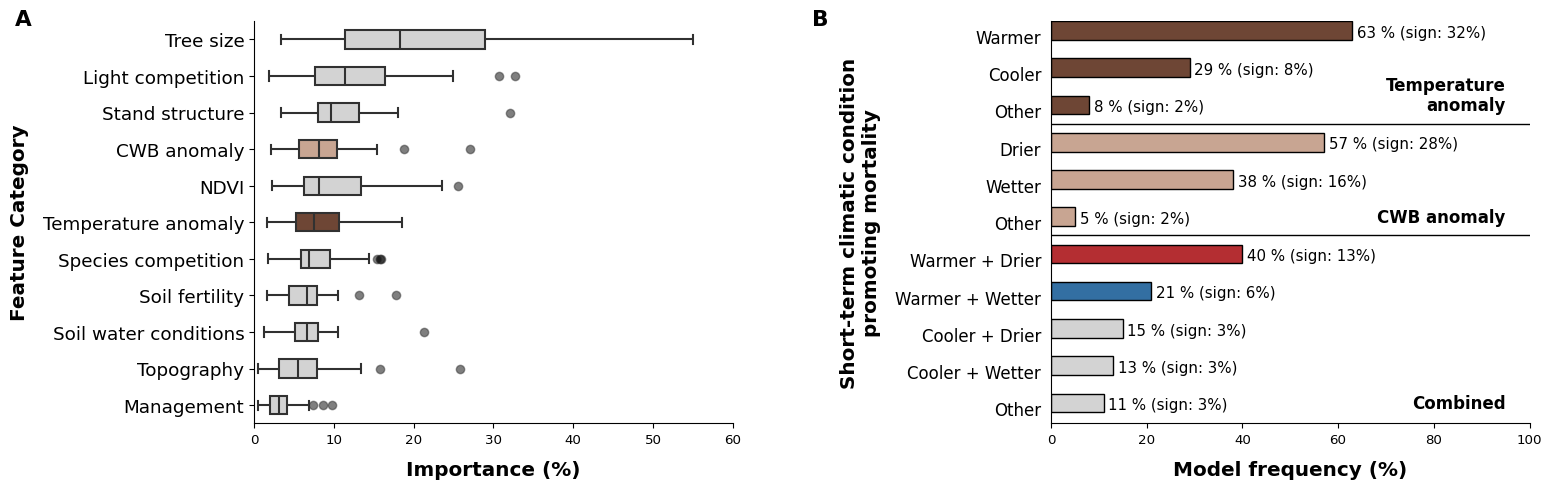

dataset
Tree Size                21.79
Light Competition        12.63
Stand Structure          10.68
NDVI                     10.05
SPEI                      8.65
Temperature               8.01
Species Competition       7.89
Soil Water Conditions     6.64
Soil Fertility            6.44
Topography                5.97
Management                3.31
dtype: float64

Sum of Stand-describing variables: 53.0
Sum of Climate-describing variables: 16.66
Sum of Soil-describing variables: 13.0
Sum of NDVI variables: 10.0

 
 --- top9 ---


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/4031766469.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot["perc_sign"] = df_plot["perc_sign"].fillna(df_plot["group_size_rel"])
/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/4031766469.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_plot["perc_ns"] = df_plot["perc_ns"].fillna(0)


,change_simple,group_size_rel,pattern,ns,sig,perc_sign,perc_ns
0,warmer,86,warmer,0.21466,0.78534,67.539267,18.460733
1,cooler,12,cooler,0.365385,0.634615,7.615385,4.384615
2,unclear (temp),2,ns (temp),0.625,0.375,0.750000,1.250000
3,drier,58,drier,0.341085,0.658915,38.217054,19.782946
4,wetter,37,wetter,0.359756,0.640244,23.689024,13.310976
5,unclear (spei),5,ns (spei),0.45,0.55,2.750000,2.250000
6,warmer_drier,52,warmer_drier,0.495614,0.504386,26.228070,25.771930
7,warmer_wetter,30,warmer_wetter,0.567164,0.432836,12.985075,17.014925
8,cooler_drier,6,cooler_drier,0.285714,0.714286,4.285714,1.714286
9,unclear,6,ns,0.535714,0.464286,2.785714,3.214286


🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_10663/1382593571.py:209: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(ytick_labels, fontsize=base_fontsize * 1)


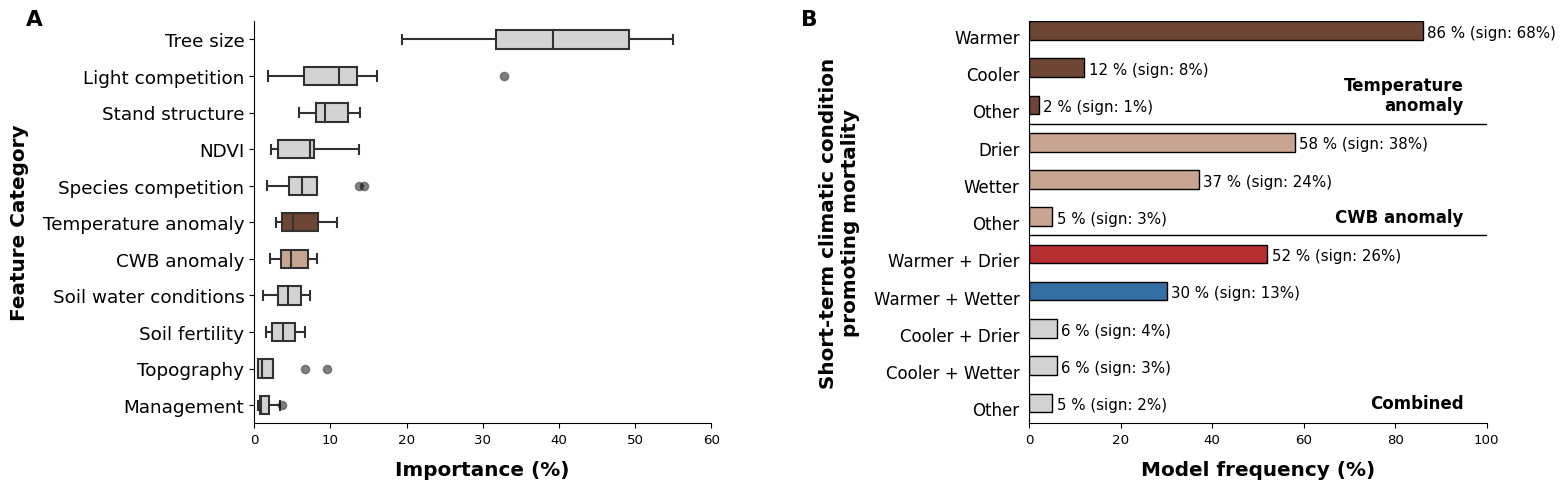

dataset
Tree Size                40.70
Light Competition        11.69
Stand Structure          10.02
Species Competition       7.16
NDVI                      6.74
Temperature               6.12
SPEI                      5.09
Soil Water Conditions     4.44
Soil Fertility            4.00
Topography                2.61
Management                1.63
dtype: float64

Sum of Stand-describing variables: 70.0
Sum of Climate-describing variables: 11.21
Sum of Soil-describing variables: 8.0
Sum of NDVI variables: 7.0

 


In [27]:
# ! Get final df for plotting
for all_or_top9 in ["all", "top9"]:
    print(f" --- {all_or_top9} ---")

    df_tmp = df_vimp.copy()
    if all_or_top9 == "top9":
        df_tmp = df_tmp[df_tmp["species"].isin(top9)]

    if all_or_top9 == "all":
        df_plot = pd.merge(
            patterns_merged_allspecies,
            df_significance_all_species,
            left_on="change_simple",
            right_on="pattern",
            how="left",
        )
        left_ylim = 60
        ytick_labels = [
            "Warmer".title(),
            "Cooler".title(),
            "Other".title(),
            "Drier".title(),
            "Wetter".title(),
            "Other".title(),
            "Warmer + Drier".title(),
            "Warmer + Wetter".title(),
            "Cooler + Drier".title(),
            "Cooler + Wetter".title(),
            "Other".title(),
        ]
    else:
        df_plot = pd.merge(
            patterns_merged_top9,
            df_significance_top9,
            left_on="change_simple",
            right_on="pattern",
            how="left",
        )
        left_ylim = 60

    # Split group size into ns and sig
    df_plot["perc_sign"] = df_plot["group_size_rel"] * (1 - df_plot["ns"])
    df_plot["perc_ns"] = df_plot["group_size_rel"] * df_plot["ns"]

    # Fix the perc_xxx columns where ns was NA. FIll with group_size_rel
    df_plot["perc_sign"] = df_plot["perc_sign"].fillna(df_plot["group_size_rel"])
    df_plot["perc_ns"] = df_plot["perc_ns"].fillna(0)

    # Switch ns for unclear
    df_plot["change_simple"] = df_plot["change_simple"].replace(
        {"ns": "unclear", "ns (spei)": "unclear (spei)", "ns (temp)": "unclear (temp)"}
    )

    # Show
    display(
        df_plot[
            [
                "change_simple",
                "group_size_rel",
                "pattern",
                "ns",
                "sig",
                "perc_sign",
                "perc_ns",
            ]
        ]
    )

    # ! Make Plot
    color_temp = "#77422C"
    color_spei = "#D1A289"
    color_rest = "lightgrey"
    color_wd = sns.color_palette("Reds", 3)[-1]
    color_ww = sns.color_palette("Blues", 3)[-1]
    color_other = "lightgrey"

    plot_bars_dataset_pattern(
        df_plot,
        df_tmp,
        all_or_top9=all_or_top9,
        color_temp=color_temp,
        color_spei=color_spei,
        color_rest=color_rest,
        color_wd=color_wd,
        color_ww=color_ww,
        color_other=color_other,
        filepath=f"{dir_today}/{all_or_top9}.png",
        ytick_labels=ytick_labels,
        left_ylim=left_ylim,
    )

    # ! Importance distribution
    df_tmp = df_tmp.drop(columns=["species", "model"]).mean()
    imp_stand = (
        df_tmp["Light Competition"]
        + df_tmp["Species Competition"]
        + df_tmp["Stand Structure"]
        + df_tmp["Tree Size"]
    ).round(0)

    imp_climate = (df_tmp["Temperature"] + df_tmp["SPEI"]).round(2)
    imp_soil = (df_tmp["Soil Fertility"] + df_tmp["Soil Water Conditions"]).round(0)
    imp_ndvi = (df_tmp["NDVI"]).round(0)

    display(df_tmp.round(2).sort_values(ascending=False))
    print(f"Sum of Stand-describing variables: {imp_stand}")
    print(f"Sum of Climate-describing variables: {imp_climate}")
    print(f"Sum of Soil-describing variables: {imp_soil}")
    print(f"Sum of NDVI variables: {imp_ndvi}\n\n ")

---
